## Setup

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install ultralytics

In [ ]:
import ultralytics
from ultralytics import YOLO
from google.colab import files
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
import splitfolders
from PIL import Image
from IPython.display import display
from glob import glob
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d trainingdatapro/parking-space-detection-dataset
!kaggle datasets download -d duythanhng/parking-lot-database-for-yolo

Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/parking-space-detection-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 69% 29.0M/42.3M [00:00<00:00, 88.3MB/s]
100% 42.3M/42.3M [00:00<00:00, 92.8MB/s]
Dataset URL: https://www.kaggle.com/datasets/duythanhng/parking-lot-database-for-yolo
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 1.90G/1.91G [00:18<00:00, 115MB/s]
100% 1.91G/1.91G [00:18<00:00, 111MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('parking-space-detection-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('./dataset')

In [ ]:
import zipfile
with zipfile.ZipFile('parking-lot-database-for-yolo.zip', 'r') as zip_ref:
  zip_ref.extractall('./dataset2')

## Pré Processamento

In [ ]:
# Input paths
XML_FILE = "dataset/annotations.xml"  # Update with your actual XML path
OUTPUT_DIR = "dataset/labels"
IMAGE_DIR = "dataset/images"  # Directory where images are stored

# Class mapping
CLASS_NAMES = {
    "free_parking_space": 0,
    "not_free_parking_space": 1,
    "partially_free_parking_space": 2
}

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def convert_polygon_to_yolo_bbox(polygon_points, img_width, img_height):
    """ Convert polygon points to YOLO (x_center, y_center, width, height) format """
    x_coords = [float(p.split(",")[0]) for p in polygon_points]
    y_coords = [float(p.split(",")[1]) for p in polygon_points]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return (x_center, y_center, width, height)

def parse_cvat_xml(xml_file):
    """ Parse CVAT XML and convert to YOLO format """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for image in root.findall("image"):
        img_name = image.get("name")
        img_width = int(image.get("width"))
        img_height = int(image.get("height"))

        label_file = os.path.join(OUTPUT_DIR, os.path.basename(img_name).replace(".png", ".txt"))

        with open(label_file, "w") as f:
            for polygon in image.findall("polygon"):
                label = polygon.get("label")
                if label not in CLASS_NAMES:
                    continue  # Skip unknown labels

                class_id = CLASS_NAMES[label]
                points = polygon.get("points").split(";")
                yolo_bbox = convert_polygon_to_yolo_bbox(points, img_width, img_height)

                f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

        print(f"✅ Converted: {img_name} -> {label_file}")

# Run conversion
parse_cvat_xml(XML_FILE)
print("🚀 Conversion complete! YOLO labels saved in:", OUTPUT_DIR)


✅ Converted: images/0.png -> dataset/labels/0.txt
✅ Converted: images/1.png -> dataset/labels/1.txt
✅ Converted: images/10.png -> dataset/labels/10.txt
✅ Converted: images/11.png -> dataset/labels/11.txt
✅ Converted: images/12.png -> dataset/labels/12.txt
✅ Converted: images/13.png -> dataset/labels/13.txt
✅ Converted: images/14.png -> dataset/labels/14.txt
✅ Converted: images/15.png -> dataset/labels/15.txt
✅ Converted: images/17.png -> dataset/labels/17.txt
✅ Converted: images/18.png -> dataset/labels/18.txt
✅ Converted: images/19.png -> dataset/labels/19.txt
✅ Converted: images/2.png -> dataset/labels/2.txt
✅ Converted: images/20.png -> dataset/labels/20.txt
✅ Converted: images/21.png -> dataset/labels/21.txt
✅ Converted: images/22.png -> dataset/labels/22.txt
✅ Converted: images/24.png -> dataset/labels/24.txt
✅ Converted: images/25.png -> dataset/labels/25.txt
✅ Converted: images/26.png -> dataset/labels/26.txt
✅ Converted: images/27.png -> dataset/labels/27.txt
✅ Converted: image

In [ ]:
!pip install split-folders

In [ ]:
# Define the input and output directories
input_dir = "dataset"  # Path to your dataset
output_dir = "split_dataset"  # Path to save the split dataset

# Split the dataset (e.g., 90% train, 10% validation)
splitfolders.ratio(
    input_dir,
    output=output_dir,
    seed=42,  # Random seed for reproducibility
    ratio=(0.9, 0.1),  # Train/validation split ratio
    group_prefix=None,  # Preserve folder structure
    move=False,  # Copy files instead of moving them
)

print("Dataset split completed!")

Copying files: 90 files [00:00, 1932.71 files/s]

Dataset split completed!


In [ ]:
def plot_images(image_paths):
  # Open images
  images = [Image.open(img_path) for img_path in image_paths]

  # Resize images to a fixed size (optional)
  resized_images = [img.resize((600, 200)) for img in images]

  # Define grid parameters
  images_per_row = 2  # Number of images per row
  image_width = resized_images[0].width  # Width of each image
  image_height = resized_images[0].height  # Height of each image

  # Calculate grid size
  num_images = len(resized_images)
  num_rows = (num_images + images_per_row - 1) // images_per_row  # Number of rows needed
  grid_width = images_per_row * image_width  # Total width of the grid
  grid_height = num_rows * image_height  # Total height of the grid

  # Create a new image to hold the grid
  grid_image = Image.new("RGB", (grid_width, grid_height))

  # Paste images into the grid
  for idx, img in enumerate(resized_images):
      x_offset = (idx % images_per_row) * image_width  # Calculate x position
      y_offset = (idx // images_per_row) * image_height  # Calculate y position
      grid_image.paste(img, (x_offset, y_offset))

  # Display the grid
  display(grid_image)

In [ ]:
YoloFolder = "dataset2/PKLotYoloData/"
SubDirs = ["UFPR04/Sunny/", "UFPR04/Rainy/", "UFPR04/Cloudy/", "UFPR05/Sunny/", "UFPR05/Rainy/", "UFPR05/Cloudy/", "PUCPR/Sunny/","PUCPR/Rainy/", "PUCPR/Cloudy/"]
train_txt = "dataset2/train.txt"
val_txt = "dataset2/val.txt"

In [ ]:
percentage_train = 80

data_list = {
    "train": [],
    "valid": []
}

def appendData(_images, type):
    for img in _images:
        data_list[type].append(img)

for _folder in SubDirs:
    folder = YoloFolder + "HasXML/" + _folder
    dir_content = [d for d in os.listdir(os.path.join(folder)) if os.path.isdir(os.path.join(folder,d))]
    for d in dir_content:
        folder_path = os.path.join(folder,d)
        images = glob(os.path.join(folder_path, "*.jpg"))
        random.shuffle(images)
        total = len(images)
        train_data_amount = round(total / 100 * percentage_train)
        train_data = images[:train_data_amount]
        appendData(train_data, "train")
        if len(train_data) < total:
            val_data = images[train_data_amount:]
            appendData(val_data, "valid")

with open(train_txt, 'w') as outfile:
    outfile.write("\n".join(data_list["train"]))
with open(val_txt, 'w') as outfile:
    outfile.write("\n".join(data_list["valid"]))

In [ ]:
%%writefile pklot.yaml
path: "/content/"
train: dataset2/train.txt
val: dataset2/val.txt
nc: 2
names: ['free_parking_space', 'not_free_parking_space']

Writing pklot.yaml


In [ ]:
# Carregar o CSV
def plotvalidations(metrics):
  df = pd.read_csv(f"{metrics.save_dir}/results.csv")

  # Plotar as curvas de loss
  plt.figure(figsize=(4, 3))
  plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
  plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()
  plt.show()

  # Plotar as métricas de validação
  plt.figure(figsize=(4, 6))
  plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50")
  plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP50-95")
  plt.xlabel("Epochs")
  plt.ylabel("mAP")
  plt.title("Validation mAP")
  plt.legend()
  plt.show()

In [ ]:
def is_image_corrupted(image_path):
    """
    Check if an image is corrupted.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify that the file is a valid image
        return False
    except Exception as e:
        print(f"Corrupted image: {image_path} - {e}")
        return True

def is_label_corrupted(label_path, image_width, image_height):
    """
    Check if a label file is corrupted.
    """
    if not os.path.exists(label_path):
        print(f"Missing label file: {label_path}")
        return True

    with open(label_path, "r") as label_file:
        lines = label_file.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:  # YOLO format: <class_id> <x_center> <y_center> <width> <height>
            return True

        try:
            class_id, x_center, y_center, width, height = map(float, parts)
            # Check if values are normalized (between 0 and 1)
            if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1):
                return True
        except ValueError:
            return True

    return False

def check_corrupted_images_and_labels_from_file(file_path):
    """
    Check for corrupted images and labels listed in a file (e.g., train.txt or val.txt).
    """
    corrupted_images = []
    corrupted_labels = []

    idx = 0
    with open(file_path, "r") as file:
        for line in file:
            image_path = line.strip()  # Remove any extra whitespace or newlines
            label_path = image_path.replace("images", "labels").replace(".jpg", ".txt").replace(".png", ".txt")

            # Check if the image is corrupted
            if is_image_corrupted(image_path):
                corrupted_images.append(image_path)
                continue  # Skip checking labels if the image is corrupted

            # Check if the label is corrupted
            idx = idx+1
            if is_label_corrupted(label_path, image_width=640, image_height=640):  # Adjust image size as needed
                corrupted_labels.append(label_path)

    return corrupted_images, corrupted_labels, idx

# Example usage
train_file = "dataset2/train.txt"
val_file = "dataset2/val.txt"

# Check for corrupted images and labels in train.txt and val.txt
corrupted_train_images, corrupted_train_labels,qtdLabels = check_corrupted_images_and_labels_from_file(train_file)
corrupted_val_images, corrupted_val_labels,qtdval = check_corrupted_images_and_labels_from_file(val_file)

print(f"Found {len(corrupted_train_images)} corrupted images and {len(corrupted_train_labels)} corrupted labels in train.txt. {qtdLabels} files")
print(f"Found {len(corrupted_val_images)} corrupted images and {len(corrupted_val_labels)} corrupted labels in val.txt. {qtdval} files")

Found 0 corrupted images and 395 corrupted labels in train.txt. 4989 files
Found 0 corrupted images and 97 corrupted labels in val.txt. 1245 files


In [ ]:
def remove_corrupted_images_and_labels_from_file(file_path, corrupted_images, corrupted_labels):
    """
    Remove corrupted images and labels from a file (e.g., train.txt or val.txt).
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Filter out corrupted images and labels
    valid_lines = []
    for line in lines:
        image_path = line.strip()
        label_path = image_path.replace("images", "labels").replace(".jpg", ".txt").replace(".png", ".txt")

        if image_path not in corrupted_images and label_path not in corrupted_labels:
            valid_lines.append(line)

    # Write the updated list back to the file
    with open(file_path, "w") as file:
        file.writelines(valid_lines)

    print(f"Updated {file_path} to exclude {len(corrupted_images)} corrupted images and {len(corrupted_labels)} corrupted labels.")

# Example usage
remove_corrupted_images_and_labels_from_file(train_file, corrupted_train_images, corrupted_train_labels)
remove_corrupted_images_and_labels_from_file(val_file, corrupted_val_images, corrupted_val_labels)

Updated dataset2/train.txt to exclude 0 corrupted images and 395 corrupted labels.
Updated dataset2/val.txt to exclude 0 corrupted images and 97 corrupted labels.


## Treinamento

In [ ]:
model = YOLO("yolov8n.pt")

metrics = model.train(
    data="pklot.yaml",
    epochs=50,
    pretrained=True,
    imgsz=720,
    iou=0.8,
    visualize=True,
    augment=True,
    box=7.5,
    patience=10,  # Early stopping
    batch=32  # Tamanho do batch ajustado
)# train the model

New https://pypi.org/project/ultralytics/8.3.79 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=pklot.yaml, epochs=50, time=None, patience=10, batch=32, imgsz=720, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.8, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

train: Scanning dataset2/PKLotYoloData/HasXML/PUCPR/Cloudy/2012-09-12... 4594 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4594/4594 [00:03<00:00, 1186.56it/s]


train: New cache created: dataset2/PKLotYoloData/HasXML/PUCPR/Cloudy/2012-09-12.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning dataset2/PKLotYoloData/HasXML/PUCPR/Cloudy/2012-09-12... 1148 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1148/1148 [00:01<00:00, 880.63it/s]

val: New cache created: dataset2/PKLotYoloData/HasXML/PUCPR/Cloudy/2012-09-12.cache


Plotting labels to runs/detect/train52/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 8 dataloader workers
Logging results to runs/detect/train52
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      18.5G      1.648      1.573      1.141       1858        736: 100%|██████████| 144/144 [00:56<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


                   all       1148      66584      0.927      0.924      0.976      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      16.9G      1.067     0.6185     0.9209       2190        736: 100%|██████████| 144/144 [00:54<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


                   all       1148      66584      0.986      0.987      0.994      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      20.1G     0.9368     0.5306     0.8856       1636        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.59it/s]


                   all       1148      66584      0.992      0.994      0.994      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.1G     0.8566      0.488     0.8678       1675        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]


                   all       1148      66584      0.996      0.996      0.995      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       9.9G     0.7976       0.45     0.8558       1851        736: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


                   all       1148      66584      0.996      0.996      0.994      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        14G     0.7358     0.4237      0.844       1724        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]


                   all       1148      66584      0.997      0.997      0.994      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50        12G     0.6851     0.3976     0.8341       2146        736: 100%|██████████| 144/144 [00:53<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.76it/s]

                   all       1148      66584      0.998      0.998      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.6G     0.6527      0.383     0.8279       1884        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


                   all       1148      66584      0.997      0.997      0.994      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.2G     0.6335     0.3718     0.8243       1856        736: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


                   all       1148      66584      0.997      0.998      0.994      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      14.9G     0.6118     0.3638     0.8217       1840        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]


                   all       1148      66584      0.998      0.998      0.994        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      15.6G     0.5853     0.3485     0.8178       2122        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.92it/s]

                   all       1148      66584      0.997      0.997      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      21.7G     0.5724     0.3417      0.815       1772        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]

                   all       1148      66584      0.997      0.997      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.9G     0.5676     0.3375     0.8144       1458        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all       1148      66584      0.998      0.998      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      16.7G     0.5517     0.3287     0.8114       1870        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all       1148      66584      0.998      0.998      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.5G     0.5344     0.3205     0.8096       2110        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all       1148      66584      0.998      0.998      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      15.5G     0.5234     0.3146     0.8076       2045        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.96it/s]

                   all       1148      66584      0.998      0.998      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      18.8G     0.5218     0.3152     0.8071       1847        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.998      0.999      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      16.8G     0.5069     0.3089     0.8056       1534        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all       1148      66584      0.999      0.999      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50        13G     0.4958     0.3022     0.8038       1622        736: 100%|██████████| 144/144 [00:54<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]

                   all       1148      66584      0.999      0.998      0.994      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      14.6G      0.497     0.3011      0.804       2402        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all       1148      66584      0.998      0.998      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      17.9G     0.4883     0.2967     0.8029       1517        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.999      0.998      0.994      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.1G     0.4806      0.291     0.8012       1762        736: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all       1148      66584      0.999      0.999      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      20.8G     0.4635     0.2866     0.7988       1817        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.999      0.999      0.994      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.3G     0.4618     0.2861     0.7997       1833        736: 100%|██████████| 144/144 [00:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all       1148      66584      0.998      0.999      0.994      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      18.2G     0.4571     0.2838     0.7987       1720        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all       1148      66584      0.999      0.999      0.994       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      14.3G     0.4556     0.2804     0.7979       1719        736: 100%|██████████| 144/144 [00:53<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all       1148      66584      0.999      0.999      0.994       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.6G     0.4391     0.2748     0.7963       1478        736: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all       1148      66584      0.999      0.999      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      17.6G     0.4368     0.2735     0.7956       1798        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all       1148      66584      0.998      0.999      0.994      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      20.9G     0.4305     0.2707     0.7954       2097        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all       1148      66584      0.999      0.999      0.994      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      19.1G     0.4226     0.2663     0.7946       2141        736: 100%|██████████| 144/144 [00:53<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all       1148      66584      0.999      0.999      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      15.4G     0.4212     0.2648     0.7944       2074        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]

                   all       1148      66584      0.999      0.999      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      14.5G     0.4143     0.2635     0.7936       1652        736: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all       1148      66584      0.999      0.999      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        14G     0.4062     0.2587     0.7923       2138        736: 100%|██████████| 144/144 [00:54<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all       1148      66584      0.999      0.999      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        15G     0.4037     0.2567     0.7916       1725        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all       1148      66584      0.999      0.999      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      13.7G     0.3939      0.253      0.791       1967        736: 100%|██████████| 144/144 [00:53<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all       1148      66584      0.999      0.999      0.994      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      18.6G     0.3897      0.251     0.7905       1448        736: 100%|██████████| 144/144 [00:53<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all       1148      66584      0.999      0.999      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      15.6G     0.3895     0.2508     0.7905       1721        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all       1148      66584      0.999      0.999      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      13.4G     0.3826     0.2468     0.7894       1613        736: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all       1148      66584      0.999      0.999      0.994       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.1G     0.3831     0.2476     0.7899       1854        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all       1148      66584      0.999      0.999      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.3G     0.3761     0.2437     0.7888       2077        736: 100%|██████████| 144/144 [00:54<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all       1148      66584      0.999      0.999      0.994      0.971


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       6.7G     0.3477     0.2271     0.7808        971        736: 100%|██████████| 144/144 [00:42<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.999      0.999      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       6.7G     0.3246     0.2168     0.7783       1127        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all       1148      66584      0.999      0.999      0.994      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       6.7G     0.3152     0.2121     0.7772        972        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all       1148      66584      0.999      0.999      0.994      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       6.7G       0.31     0.2092     0.7767        833        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.999      0.999      0.994      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       6.7G     0.2984     0.2046      0.775        900        736: 100%|██████████| 144/144 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.999      0.999      0.994      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.7G     0.2911     0.2021      0.775       1064        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all       1148      66584      0.999      0.999      0.994      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       6.7G     0.2864     0.1992     0.7739       1093        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all       1148      66584      0.999      0.999      0.994      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       6.7G     0.2812     0.1966     0.7739       1012        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.07it/s]

                   all       1148      66584      0.999      0.999      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       6.7G     0.2751     0.1942     0.7731        972        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all       1148      66584      0.999      0.999      0.994      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       6.7G     0.2692     0.1919     0.7726       1085        736: 100%|██████████| 144/144 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all       1148      66584      0.999      0.999      0.994       0.98



50 epochs completed in 0.815 hours.
Optimizer stripped from runs/detect/train52/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train52/weights/best.pt, 6.2MB

Validating runs/detect/train52/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:32<00:00,  1.83s/it]


                   all       1148      66584      0.998      0.999      0.994      0.966
    free_parking_space        969      35941      0.998      0.999      0.995      0.968
not_free_parking_space        933      30643      0.997      0.999      0.994      0.965
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train52


runs/detect/train52


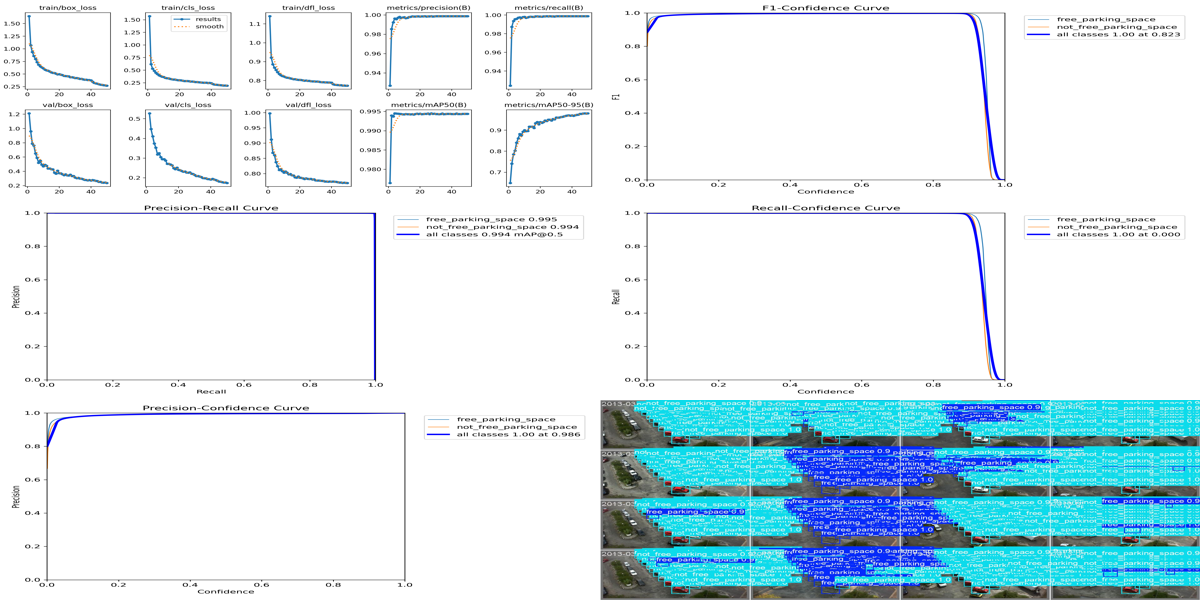

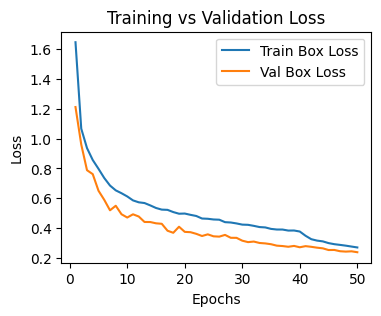

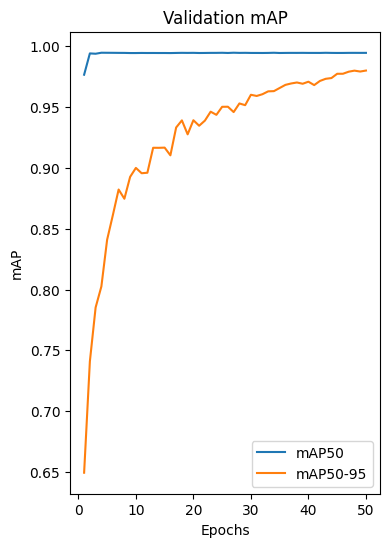

In [ ]:
# List of image paths
image_paths = [
    f"{metrics.save_dir}/results.png",
    f"{metrics.save_dir}/F1_curve.png",
    f"{metrics.save_dir}/PR_curve.png",
    f"{metrics.save_dir}/R_curve.png",
    f"{metrics.save_dir}/P_curve.png",
    f"{metrics.save_dir}/val_batch0_pred.jpg",
]

print(metrics.save_dir)
plot_images(image_paths)
plotvalidations(metrics)

In [ ]:
metrics2 = model.train(
    data="parking.yaml",
    epochs=1000,
    pretrained=True,
    iou=0.6,
    visualize=True,
    patience=15,  # Early stopping
    augment=True,  # Aumento de dados
    batch=2  # Tamanho do batch ajustado
)# train the model

New https://pypi.org/project/ultralytics/8.3.79 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=parking.yaml, epochs=1000, time=None, patience=15, batch=2, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train522, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning /content/split_dataset/train/labels.cache... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/split_dataset/val/labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]


Plotting labels to runs/detect/train522/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 8 dataloader workers
Logging results to runs/detect/train522
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     1/1000       1.7G      3.338       3.72      3.138         47        736: 100%|██████████| 14/14 [00:01<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all          3         88    0.00425     0.0379    0.00223   0.000589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      1.48G      2.882      3.518      2.729         51        736: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all          3         88     0.0225      0.189     0.0258    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      1.46G      2.273      3.226      2.193         34        736: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          3         88     0.0337      0.318     0.0761     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      1.46G      2.127      2.803      2.038         22        736: 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all          3         88      0.727     0.0985      0.135     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      1.46G      1.707      2.427      1.668         75        736: 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all          3         88      0.727     0.0985      0.135     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      1.46G      1.702      2.352       1.64         58        736: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all          3         88      0.732      0.217      0.194      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      1.46G      1.599      2.033      1.533         63        736: 100%|██████████| 14/14 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all          3         88      0.732      0.217      0.194      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      1.46G      1.621      2.096      1.606         55        736: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all          3         88      0.485      0.434      0.462       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      1.33G      1.465      1.706      1.521        103        736: 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

                   all          3         88      0.485      0.434      0.462       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      1.33G      1.459      1.785      1.641         24        736: 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          3         88      0.485      0.434      0.462       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      1.33G      1.377      1.632      1.487         24        736: 100%|██████████| 14/14 [00:02<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all          3         88      0.561      0.477      0.545      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      1.33G      1.445      1.556      1.524        120        736: 100%|██████████| 14/14 [00:02<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

                   all          3         88      0.561      0.477      0.545      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      1.33G       1.38      1.442      1.545         80        736: 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

                   all          3         88      0.709      0.606      0.671      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      1.33G      1.275      1.407      1.389         31        736: 100%|██████████| 14/14 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          3         88      0.709      0.606      0.671      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      1.33G      1.302      1.461      1.465         64        736: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all          3         88      0.744      0.818      0.863      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      1.33G      1.201      1.279      1.355        102        736: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


                   all          3         88      0.744      0.818      0.863      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      1.33G      1.179      1.227      1.349         36        736: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all          3         88      0.744      0.818      0.863      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      1.33G      1.148      1.244      1.261         26        736: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all          3         88      0.923      0.797      0.879      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      1.33G       1.19      1.174      1.323         77        736: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all          3         88      0.923      0.797      0.879      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      1.33G      1.306      1.633      1.443         10        736: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all          3         88       0.89      0.795      0.866       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      1.33G      1.141      1.158      1.317         47        736: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          3         88       0.89      0.795      0.866       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      1.33G      1.102      1.192      1.318         62        736: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          3         88      0.894      0.818      0.862      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      1.33G      1.079      1.169      1.295         30        736: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          3         88      0.894      0.818      0.862      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      1.33G      1.131      1.131       1.32         37        736: 100%|██████████| 14/14 [00:01<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]

                   all          3         88      0.885      0.864      0.872      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      1.33G     0.9738      1.096      1.215         47        736: 100%|██████████| 14/14 [00:00<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.20it/s]


                   all          3         88      0.885      0.864      0.872      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      1.33G      1.031      1.124      1.236         69        736: 100%|██████████| 14/14 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]

                   all          3         88      0.885      0.864      0.872      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      1.33G      1.003      1.083      1.174         77        736: 100%|██████████| 14/14 [00:01<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]

                   all          3         88      0.908      0.734      0.824      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      1.33G      1.064      1.125      1.285         48        736: 100%|██████████| 14/14 [00:00<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.40it/s]

                   all          3         88      0.908      0.734      0.824      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      1.33G     0.9477      1.059      1.172         87        736: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.59it/s]

                   all          3         88      0.739      0.788      0.785      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      1.33G     0.9292      1.015      1.144         23        736: 100%|██████████| 14/14 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.15it/s]

                   all          3         88      0.739      0.788      0.785      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      1.33G     0.9053     0.9656      1.147        105        736: 100%|██████████| 14/14 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.95it/s]

                   all          3         88      0.841      0.712       0.79       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      1.33G      1.056      1.016      1.194        109        736: 100%|██████████| 14/14 [00:00<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]

                   all          3         88      0.841      0.712       0.79       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      1.33G     0.9348      0.988      1.172         67        736: 100%|██████████| 14/14 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.49it/s]

                   all          3         88      0.841      0.712       0.79       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      1.33G     0.8293     0.8355      1.061         36        736: 100%|██████████| 14/14 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.97it/s]

                   all          3         88      0.928       0.82      0.857        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      1.33G     0.9194      0.879      1.153         49        736: 100%|██████████| 14/14 [00:00<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]

                   all          3         88      0.928       0.82      0.857        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      1.33G     0.9437     0.9733      1.156         34        736: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]

                   all          3         88      0.935      0.808      0.879      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      1.33G     0.9653      0.952      1.176         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.90it/s]


                   all          3         88      0.935      0.808      0.879      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      1.33G     0.8721      0.885      1.082        163        736: 100%|██████████| 14/14 [00:01<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.65it/s]

                   all          3         88      0.921      0.843      0.901      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      1.33G     0.9458      1.048      1.212         48        736: 100%|██████████| 14/14 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]

                   all          3         88      0.921      0.843      0.901      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      1.33G     0.8602     0.8447       1.08         13        736: 100%|██████████| 14/14 [00:01<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.74it/s]

                   all          3         88      0.895      0.871       0.92      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      1.33G     0.8811     0.9043      1.108         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]

                   all          3         88      0.895      0.871       0.92      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      1.33G     0.8153     0.8619      1.073         39        736: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all          3         88      0.895      0.871       0.92      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      1.33G     0.7961     0.8662      1.062         41        736: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all          3         88      0.888      0.871      0.916      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      1.33G     0.8754     0.9015       1.07         37        736: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          3         88      0.888      0.871      0.916      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      1.33G     0.8907     0.8701      1.119         62        736: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all          3         88      0.882      0.826      0.899      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      1.33G     0.8949     0.8535      1.096        103        736: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all          3         88      0.882      0.826      0.899      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      1.33G     0.8239     0.8072      1.058         58        736: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all          3         88      0.887      0.821       0.89       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      1.33G     0.8144     0.7858      1.085         32        736: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all          3         88      0.887      0.821       0.89       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      1.33G     0.8593     0.8315      1.101         42        736: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all          3         88      0.887      0.821       0.89       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      1.33G     0.8274     0.8092      1.086         16        736: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all          3         88      0.901      0.848      0.883      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      1.33G      0.904     0.8994      1.116        112        736: 100%|██████████| 14/14 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all          3         88      0.901      0.848      0.883      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      1.33G     0.8045     0.8022      1.053        100        736: 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all          3         88      0.935      0.848      0.884      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      1.33G     0.7877     0.7493      1.023         64        736: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          3         88      0.935      0.848      0.884      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      1.33G     0.7616     0.8196       1.03         37        736: 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all          3         88      0.968      0.841      0.879      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      1.33G     0.7418     0.7407      1.024         35        736: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all          3         88      0.968      0.841      0.879      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      1.33G     0.9258      1.025      1.145         10        736: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          3         88      0.972      0.841      0.895      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      1.33G     0.8475     0.8797      1.109         16        736: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          3         88      0.972      0.841      0.895      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      1.33G     0.7173     0.7347     0.9977         35        736: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all          3         88      0.972      0.841      0.895      0.746


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 43, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

58 epochs completed in 0.062 hours.
Optimizer stripped from runs/detect/train522/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train522/weights/best.pt, 6.3MB

Validating runs/detect/train522/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


                   all          3         88      0.869      0.787      0.894      0.742
    free_parking_space          3         22      0.774      0.773      0.845      0.701
not_free_parking_space          3         66      0.964      0.801      0.943      0.783
Speed: 0.3ms preprocess, 134.6ms inference, 0.0ms loss, 12.0ms postprocess per image
Results saved to runs/detect/train522


runs/detect/train522


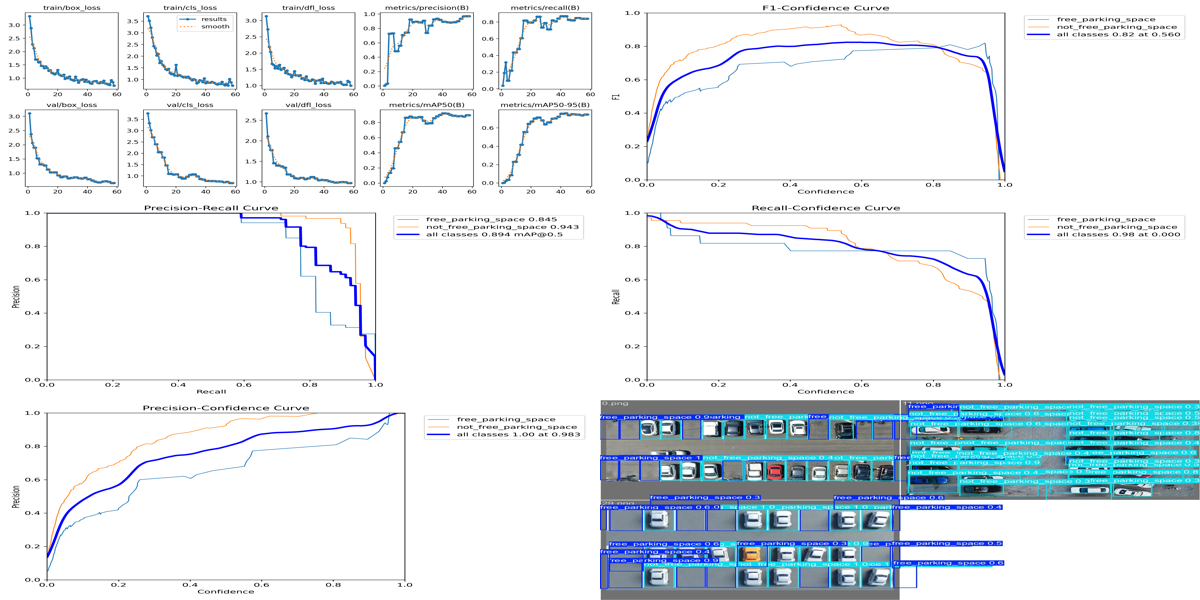

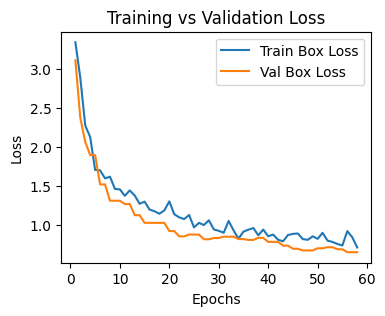

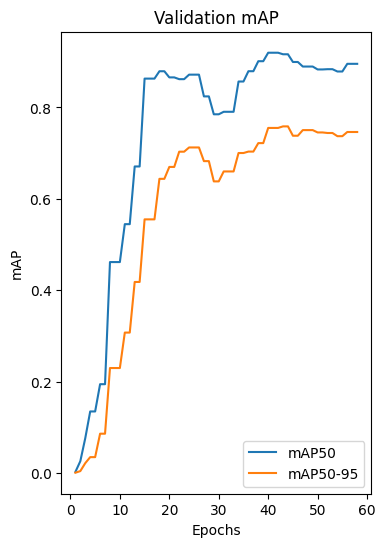

In [ ]:
# List of image paths
image_paths = [
    f"{metrics2.save_dir}/results.png",
    f"{metrics2.save_dir}/F1_curve.png",
    f"{metrics2.save_dir}/PR_curve.png",
    f"{metrics2.save_dir}/R_curve.png",
    f"{metrics2.save_dir}/P_curve.png",
    f"{metrics2.save_dir}/val_batch0_pred.jpg",
]

print(metrics2.save_dir)
plot_images(image_paths)
plotvalidations(metrics2)

In [ ]:
# Load a model
model = YOLO(f"{metrics.save_dir}/weights/best.pt")     # load a pretrained model (recommended for training)

# Use the model
metrics3 = model.train(
    data="parking.yaml",
    epochs=1000,
    pretrained=True,
    iou=0.6,
    visualize=True,
    patience=15,  # Early stopping
    augment=True,  # Aumento de dados
    weight_decay=0.0010,  # Regularização L2
    dropout=0.25,  # Dropout
    lr0=0.0005,  # Taxa de aprendizado reduzida
    batch=2  # Tamanho do batch ajustado
)# train the model

New https://pypi.org/project/ultralytics/8.3.79 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train52/weights/best.pt, data=parking.yaml, epochs=1000, time=None, patience=15, batch=2, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train53, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning /content/split_dataset/train/labels.cache... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/split_dataset/val/labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]


Plotting labels to runs/detect/train53/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 8 dataloader workers
Logging results to runs/detect/train53
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      1.38G      3.338       3.72      3.138         47        736: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]

                   all          3         88    0.00425     0.0379    0.00223   0.000589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      1.35G      2.882      3.518       2.73         51        736: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

                   all          3         88     0.0226      0.189     0.0258    0.00389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      1.33G      2.275      3.226      2.195         34        736: 100%|██████████| 14/14 [00:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          3         88     0.0344      0.326     0.0784     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      1.33G      2.132      2.807      2.045         22        736: 100%|██████████| 14/14 [00:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]

                   all          3         88      0.729     0.0985      0.135     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      1.33G      1.711      2.429      1.672         75        736: 100%|██████████| 14/14 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]

                   all          3         88      0.729     0.0985      0.135     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      1.33G      1.706      2.354      1.642         58        736: 100%|██████████| 14/14 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]

                   all          3         88      0.719       0.22      0.201     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      1.33G      1.607      2.033      1.537         63        736: 100%|██████████| 14/14 [00:01<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.41it/s]

                   all          3         88      0.719       0.22      0.201     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      1.33G      1.626      2.096      1.609         55        736: 100%|██████████| 14/14 [00:01<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]

                   all          3         88      0.406      0.462      0.445      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      1.33G      1.448      1.708      1.507        103        736: 100%|██████████| 14/14 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]

                   all          3         88      0.406      0.462      0.445      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      1.33G      1.468      1.783      1.654         24        736: 100%|██████████| 14/14 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]


                   all          3         88      0.406      0.462      0.445      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      1.33G      1.389      1.633      1.494         24        736: 100%|██████████| 14/14 [00:00<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]

                   all          3         88      0.568       0.48      0.554      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      1.33G      1.452      1.554      1.525        120        736: 100%|██████████| 14/14 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.03it/s]

                   all          3         88      0.568       0.48      0.554      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      1.33G      1.388      1.442      1.551         80        736: 100%|██████████| 14/14 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]

                   all          3         88      0.637      0.616      0.676      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      1.33G      1.273      1.397      1.388         31        736: 100%|██████████| 14/14 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]

                   all          3         88      0.637      0.616      0.676      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      1.33G      1.308      1.455       1.47         64        736: 100%|██████████| 14/14 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]

                   all          3         88      0.781      0.841      0.856      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      1.33G        1.2      1.281      1.352        102        736: 100%|██████████| 14/14 [00:00<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.37it/s]

                   all          3         88      0.781      0.841      0.856      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      1.33G      1.177      1.227      1.344         36        736: 100%|██████████| 14/14 [00:00<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]

                   all          3         88      0.781      0.841      0.856      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      1.33G       1.14      1.237      1.258         26        736: 100%|██████████| 14/14 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.85it/s]

                   all          3         88      0.918      0.795       0.87      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      1.33G      1.196      1.177       1.33         77        736: 100%|██████████| 14/14 [00:00<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.88it/s]

                   all          3         88      0.918      0.795       0.87      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      1.33G      1.337      1.577      1.468         10        736: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.07it/s]

                   all          3         88       0.78      0.856      0.848      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      1.33G      1.139      1.161      1.314         47        736: 100%|██████████| 14/14 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.27it/s]

                   all          3         88       0.78      0.856      0.848      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      1.33G      1.105       1.19      1.322         62        736: 100%|██████████| 14/14 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]

                   all          3         88      0.833      0.864       0.84      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      1.33G      1.079      1.166      1.294         30        736: 100%|██████████| 14/14 [00:00<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.07it/s]

                   all          3         88      0.833      0.864       0.84      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      1.33G      1.133      1.123      1.316         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.07it/s]

                   all          3         88      0.893      0.841       0.86      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      1.33G     0.9687       1.09      1.217         47        736: 100%|██████████| 14/14 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]

                   all          3         88      0.893      0.841       0.86      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      1.33G      1.024      1.114      1.234         69        736: 100%|██████████| 14/14 [00:00<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]

                   all          3         88      0.893      0.841       0.86      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      1.33G     0.9922      1.074      1.171         77        736: 100%|██████████| 14/14 [00:00<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]

                   all          3         88      0.736      0.788      0.799      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      1.33G      1.055      1.124      1.282         48        736: 100%|██████████| 14/14 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.99it/s]

                   all          3         88      0.736      0.788      0.799      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      1.33G     0.9421      1.058      1.169         87        736: 100%|██████████| 14/14 [00:00<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.84it/s]

                   all          3         88      0.758      0.727      0.747      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      1.33G     0.9175      1.012      1.138         23        736: 100%|██████████| 14/14 [00:00<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.35it/s]

                   all          3         88      0.758      0.727      0.747      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      1.33G     0.8957     0.9638      1.138        105        736: 100%|██████████| 14/14 [00:00<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.45it/s]

                   all          3         88      0.777       0.72      0.759      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      1.33G      1.041      1.005      1.185        109        736: 100%|██████████| 14/14 [00:00<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.96it/s]

                   all          3         88      0.777       0.72      0.759      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      1.33G     0.9263     0.9914       1.17         67        736: 100%|██████████| 14/14 [00:00<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.11it/s]

                   all          3         88      0.777       0.72      0.759      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      1.33G     0.8141     0.8266      1.054         36        736: 100%|██████████| 14/14 [00:01<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.65it/s]

                   all          3         88      0.891      0.796      0.842      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      1.33G     0.9185     0.8679      1.159         49        736: 100%|██████████| 14/14 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


                   all          3         88      0.891      0.796      0.842      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      1.33G     0.9411     0.9635      1.155         34        736: 100%|██████████| 14/14 [00:00<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.58it/s]

                   all          3         88      0.936      0.833      0.868      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      1.33G      0.957     0.9485       1.17         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.29it/s]

                   all          3         88      0.936      0.833      0.868      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      1.33G     0.8699     0.8874      1.081        163        736: 100%|██████████| 14/14 [00:01<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.67it/s]

                   all          3         88      0.975      0.807      0.896      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      1.33G     0.9211      1.049      1.198         48        736: 100%|██████████| 14/14 [00:00<00:00, 15.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.94it/s]

                   all          3         88      0.975      0.807      0.896      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      1.33G     0.8505     0.8434      1.078         13        736: 100%|██████████| 14/14 [00:00<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]

                   all          3         88      0.909      0.868      0.923      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      1.33G      0.863     0.9068      1.101         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]

                   all          3         88      0.909      0.868      0.923      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      1.33G     0.8108      0.861       1.07         39        736: 100%|██████████| 14/14 [00:00<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.51it/s]

                   all          3         88      0.909      0.868      0.923      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      1.33G     0.8023     0.8568      1.065         41        736: 100%|██████████| 14/14 [00:00<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.50it/s]


                   all          3         88      0.873      0.872       0.92      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      1.33G     0.8804     0.8896      1.072         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.68it/s]

                   all          3         88      0.873      0.872       0.92      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      1.33G     0.8821     0.8579      1.115         62        736: 100%|██████████| 14/14 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.47it/s]

                   all          3         88      0.881      0.848      0.903      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      1.33G     0.8718     0.8425      1.087        103        736: 100%|██████████| 14/14 [00:00<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]

                   all          3         88      0.881      0.848      0.903      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      1.33G     0.8161     0.8079      1.056         58        736: 100%|██████████| 14/14 [00:00<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.50it/s]

                   all          3         88      0.885      0.844      0.901       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      1.33G     0.8187     0.7849      1.076         32        736: 100%|██████████| 14/14 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.62it/s]

                   all          3         88      0.885      0.844      0.901       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      1.33G     0.8607      0.828      1.096         42        736: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.78it/s]


                   all          3         88      0.885      0.844      0.901       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      1.33G     0.8257     0.8064       1.08         16        736: 100%|██████████| 14/14 [00:00<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]

                   all          3         88      0.903      0.845      0.887      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      1.33G     0.9015     0.8996       1.12        112        736: 100%|██████████| 14/14 [00:00<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]

                   all          3         88      0.903      0.845      0.887      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      1.33G     0.8103     0.8038      1.056        100        736: 100%|██████████| 14/14 [00:00<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]

                   all          3         88      0.924      0.841      0.885      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      1.33G     0.7935     0.7392      1.026         64        736: 100%|██████████| 14/14 [00:00<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]

                   all          3         88      0.924      0.841      0.885      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      1.33G      0.761      0.823      1.028         37        736: 100%|██████████| 14/14 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]

                   all          3         88      0.945      0.825      0.885      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      1.33G     0.7356     0.7382       1.02         35        736: 100%|██████████| 14/14 [00:01<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.59it/s]

                   all          3         88      0.945      0.825      0.885      0.728


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

55 epochs completed in 0.032 hours.
Optimizer stripped from runs/detect/train53/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train53/weights/best.pt, 6.3MB

Validating runs/detect/train53/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


                   all          3         88       0.84      0.841      0.901      0.756
    free_parking_space          3         22      0.742      0.773      0.849      0.719
not_free_parking_space          3         66      0.938      0.909      0.953      0.794
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train53


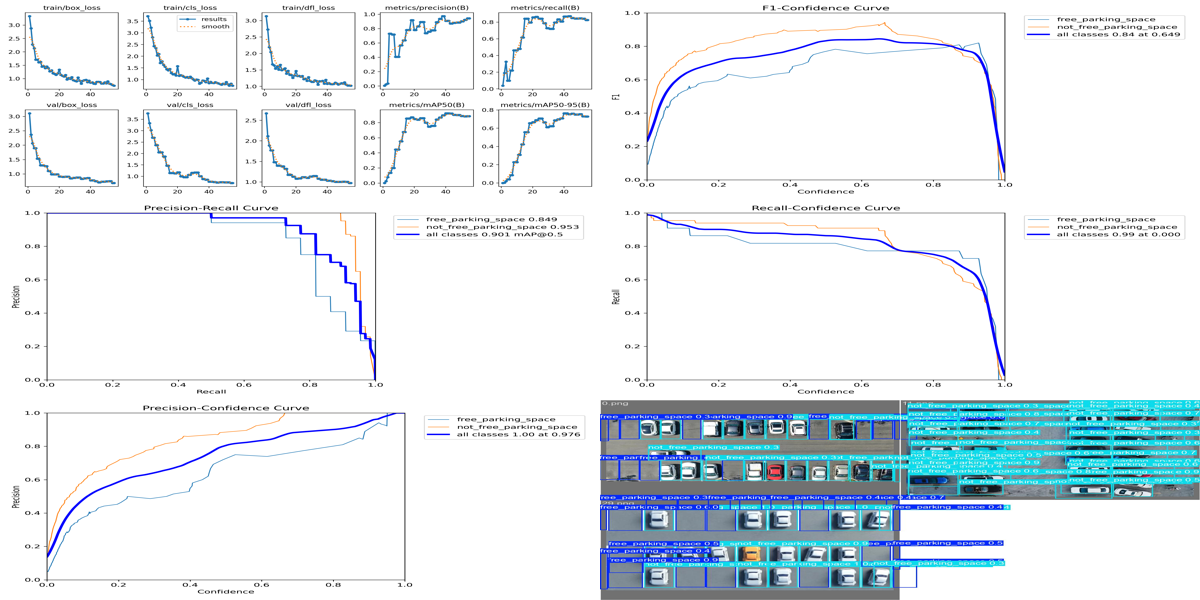

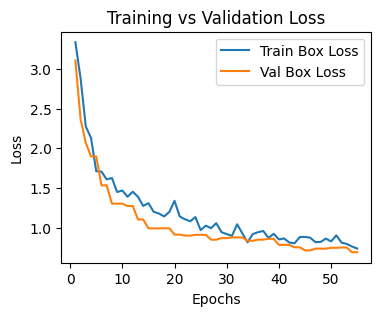

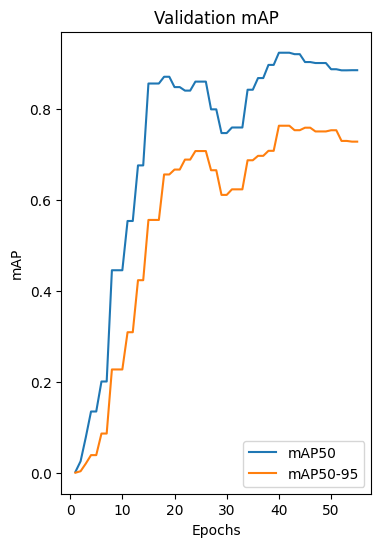

In [ ]:
# List of image paths
image_paths = [
    f"{metrics3.save_dir}/results.png",
    f"{metrics3.save_dir}/F1_curve.png",
    f"{metrics3.save_dir}/PR_curve.png",
    f"{metrics3.save_dir}/R_curve.png",
    f"{metrics3.save_dir}/P_curve.png",
    f"{metrics3.save_dir}/val_batch0_pred.jpg",
]

plot_images(image_paths)
plotvalidations(metrics3)

In [ ]:
tuning = YOLO("intersection_model.pt")

tuning.tune(data="parking.yaml")

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune5'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs/detect/tune5/tune_scatter_plots.png
Saved runs/detect/tune5/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (128.05s)
Tuner: Results saved to runs/detect/tune5
Tuner: Best fitness=0.87359 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.8635, 'metrics/recall(B)': 0.91931, 'metrics/mAP50(B)': 0.96109, 'metrics/mAP50-95(B)': 0.86387, 'val/box_loss': 0.50155, 'val/cls_loss'